In [26]:
import torch
from torchvision import transforms, datasets, models
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import numpy as np

In [27]:
# config
data_dir = '../learning/dogscats/data/dogscats/'

# Data prep

In [53]:
i_mean=[0.485, 0.456, 0.406]
i_std=[0.229, 0.224, 0.225]

data_transform = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=i_mean, std=i_std)]
)


In [62]:
train_data_img_folder = datasets.ImageFolder(data_dir + 'train/', data_transform)
train_data_loader = torch.utils.data.DataLoader(train_data_img_folder, batch_size=64, num_workers=4, shuffle=True)

test_data_img_folder = datasets.ImageFolder(data_dir + 'valid/', data_transform)
test_data_loader = torch.utils.data.DataLoader(test_data_img_folder, batch_size=64, num_workers=4, shuffle=False)

In [39]:
print (len(train_data_loader.dataset.imgs))
print (len(test_data_loader.dataset.imgs))
print next(iter(train_data_loader))[0].size()

23000
2000
torch.Size([64, 3, 224, 224])


# Visualize

In [14]:
# once you get the images out of the data loader use this to get a batch out
# make this generic enough
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot(images, title=None):
    images = images.numpy().transpose(1,2,0)
    images = images*i_std + i_mean
    images = np.clip(images, 0, 1)
    plt.figure(figsize=(20,20))
    
    plt.imshow(images)
    # show titles
    if title != None:
        plt.title(title)
    plt.pause(0.001)


# e.g. given a dataloader this is how you would show a batch of images
#inp, classes = next(iter(train_data_loader))
#imgs = torchvision.utils.make_grid(inp)
#labels = [train_dataset.classes[x] for x in classes]
#plot(imgs, labels)

In [15]:
sample_batch,labels = next(iter(train_data_loader))

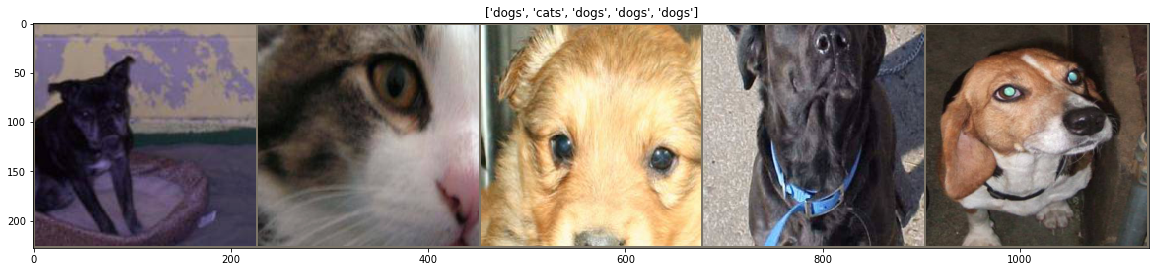

In [16]:
# show the fist 5 images
imgs = torchvision.utils.make_grid(sample_batch[:5])
classes = [train_data_img_folder.classes[x] for x in labels[:5]]
plot(imgs, classes)

# Prepare VGG model

In [78]:
model = torchvision.models.vgg16(pretrained=True)
model.cuda()

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

# Finetune

In [79]:
# freeze all the conv layers 
for p in model.features.parameters():
    p.requires_grad = False

# make the dense layers trainable
for p in model.classifier.parameters():
    p.requires_grad = True

# VGG outputs 1000 categories but we only need 2 (dogs and cats)
# There are two ways to do this.

# 1. Keep the arch as is and tinker around with the paramter of the last layer in the classifier
#    like so. Github poking around is how i got the name of the param
model.classifier[6].out_features = 2

# 2. Alternatively you can replace the whole classifier (FC). Note that
#    VGG class takes care of the flattening and it is not to be found in either feature or classifier
import torch.nn as nn
fc_layer = nn.Sequential(
    nn.Linear (25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear (4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear (4096, 2),
)

model.classifier = fc_layer.cuda()

In [80]:
criterion = nn.CrossEntropyLoss().cuda()
opt = torch.optim.SGD(model.classifier.parameters(), lr=0.01)

train_model(model, train_data_loader, opt, criterion, 5)

Epoch [1/5], Loss: 0.0542 Acc: 0.9431 P: 0.9442 R: 0.9418 
Epoch [2/5], Loss: 0.1476 Acc: 0.9590 P: 0.9649 R: 0.9525 
Epoch [3/5], Loss: 0.2088 Acc: 0.9599 P: 0.9647 R: 0.9547 
Epoch [4/5], Loss: 0.3369 Acc: 0.9609 P: 0.9644 R: 0.9571 
Epoch [5/5], Loss: 0.0057 Acc: 0.9621 P: 0.9668 R: 0.9570 


In [85]:
# Evaluate model
eval_model(model, test_data_loader)

Acc: 0.9535 P: 0.9739 R: 0.9320 


# VGG 16 Batch normalization

In [11]:
model_bn = models.vgg16_bn(pretrained=True).cuda()

# freeze all the conv layers 
for p in model_bn.features.parameters():
    p.requires_grad = False

model_bn.classifier[6].out_features = 2

In [86]:
num_epochs = 10

criterion = nn.CrossEntropyLoss().cuda()
opt = torch.optim.SGD(model_bn.classifier.parameters(), lr=0.01)

train_model(model_bn, train_data_loader, opt, criterion, num_epochs)

Epoch [1/10], Loss: 0.0494 Acc: 0.9631 P: 0.9677 R: 0.9583 
Epoch [2/10], Loss: 0.1384 Acc: 0.9651 P: 0.9702 R: 0.9597 
Epoch [3/10], Loss: 0.0346 Acc: 0.9647 P: 0.9675 R: 0.9616 
Epoch [4/10], Loss: 0.0572 Acc: 0.9661 P: 0.9696 R: 0.9623 
Epoch [5/10], Loss: 0.0284 Acc: 0.9639 P: 0.9682 R: 0.9593 
Epoch [6/10], Loss: 0.0495 Acc: 0.9668 P: 0.9707 R: 0.9626 
Epoch [7/10], Loss: 0.1749 Acc: 0.9660 P: 0.9699 R: 0.9619 
Epoch [8/10], Loss: 0.0198 Acc: 0.9673 P: 0.9712 R: 0.9633 
Epoch [9/10], Loss: 0.0919 Acc: 0.9649 P: 0.9689 R: 0.9606 
Epoch [10/10], Loss: 0.0700 Acc: 0.9670 P: 0.9702 R: 0.9637 


In [87]:
# Evaluate model
eval_model(model_bn, test_data_loader)

Acc: 0.9555 P: 0.9770 R: 0.9330 


# Optimize things a little bit
1. run the training data through the features of each model
2. store them in a file
3. load them from file
4. construct a new model that focuses on the fine tuning part
5. train and test

## Precompute the bits that do not change
The feature parts of the vgg model will not change so why repeatedly run each image through it 
when we can precompute it once and then train on its output

In [33]:
model = torchvision.models.vgg16(pretrained=True)
model.cuda()
model.eval()

feat_mdl = model.features.cuda()

feats_labels = []
conv_feats = []

for imgs, lbls in train_data_loader:
    images = Variable(imgs).cuda()
    
    output = feat_mdl(images)
    
    conv_feats.extend(output.data.cpu().numpy())
    feats_labels.extend(lbls.numpy())

save_array('./data/feats.dat', conv_feats)
save_array('./data/lbls.dat', feats_labels)

print(conv_feats[0].shape)
print(len(conv_feats))

print(feats_labels[0].shape)
print(len(feats_labels))

(512, 7, 7)
23000
()
23000


## A new model to do the fine tunning 

In [71]:
# build a model to mimic the FC component
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear (25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear (4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear (4096, 2)
        )
    
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.layer1(out)
        return out

## Load data from file and do the magic of fine tunning

In [72]:
# load data
feats_lst = load_array('data/feats.dat')
lbls_lst = load_array('data/lbls.dat')

feats_lst = torch.from_numpy(feats_lst)
lbls_lst = torch.from_numpy(lbls_lst)

In [109]:
mdl = CNN().cuda()

criterion = nn.CrossEntropyLoss().cuda()
opt = torch.optim.SGD(mdl.parameters(), lr=0.001)

num_epochs = 50
train_model(mdl, feats_lst,lbls_lst, opt, criterion, num_epochs)

Epoch [1/50], Loss: 0.1665 Acc: 0.8903 P: 0.8726 R: 0.9140 
Epoch [2/50], Loss: 0.0988 Acc: 0.9467 P: 0.9486 R: 0.9447 
Epoch [3/50], Loss: 0.0511 Acc: 0.9520 P: 0.9585 R: 0.9449 
Epoch [4/50], Loss: 0.0548 Acc: 0.9572 P: 0.9627 R: 0.9512 
Epoch [5/50], Loss: 0.0487 Acc: 0.9595 P: 0.9658 R: 0.9527 
Epoch [6/50], Loss: 0.0361 Acc: 0.9614 P: 0.9677 R: 0.9546 
Epoch [7/50], Loss: 0.0397 Acc: 0.9636 P: 0.9697 R: 0.9570 
Epoch [8/50], Loss: 0.0351 Acc: 0.9657 P: 0.9710 R: 0.9601 
Epoch [9/50], Loss: 0.0180 Acc: 0.9679 P: 0.9729 R: 0.9625 
Epoch [10/50], Loss: 0.0323 Acc: 0.9690 P: 0.9745 R: 0.9633 
Epoch [11/50], Loss: 0.0317 Acc: 0.9707 P: 0.9749 R: 0.9663 
Epoch [12/50], Loss: 0.0234 Acc: 0.9720 P: 0.9766 R: 0.9672 
Epoch [13/50], Loss: 0.0175 Acc: 0.9732 P: 0.9782 R: 0.9679 
Epoch [14/50], Loss: 0.0228 Acc: 0.9738 P: 0.9786 R: 0.9689 
Epoch [15/50], Loss: 0.0260 Acc: 0.9752 P: 0.9807 R: 0.9695 
Epoch [16/50], Loss: 0.0155 Acc: 0.9775 P: 0.9821 R: 0.9727 
Epoch [17/50], Loss: 0.0144 Acc: 

In [114]:
# Evaluate model

model.eval()
feat_mdl = model.features.cuda()

tst_feats_labels = []
tst_conv_feats = []

for imgs, lbls in test_data_loader:
    images = Variable(imgs).cuda()
    
    output = feat_mdl(images)
    
    tst_conv_feats.extend(output.data.cpu().numpy())
    tst_feats_labels.extend(lbls.numpy())

feats_lst = torch.from_numpy(np.array(tst_conv_feats))
lbls_lst = torch.from_numpy(np.array(tst_feats_labels))


In [115]:
eval_model(mdl, feats_lst, lbls_lst)

Acc: 0.9520 P: 0.9593 R: 0.9440 


# Utils

In [110]:
# a class to track and compute all model metrics
class Metrics:
    
    def __init__(self):
        self.total_pred = 0.0
        self.total_pos_pred = 0.0
        self.total_corr_pred = 0.0
        self.total_pos_corr_pred = 0.0
        self.total_pos_truth = 0.0
              
    def count(self, pred, truth):
        assert(len(pred) == len(pred))
        for i in range(len(pred)):
            self.total_pred += 1
            if pred[i] == truth[i]:
                self.total_corr_pred += 1
            
            if pred[i] == 1:
                self.total_pos_pred += 1
                if pred[i] == truth[i]:
                    self.total_pos_corr_pred += 1
            
            if truth[i] == 1:
                self.total_pos_truth += 1
            
    def compute_metrics(self):
        res = {}
        res['total'] = self.total_pos_pred
        res['accuracy'] = self.total_corr_pred/self.total_pred
        res['recall'] = self.total_pos_corr_pred/self.total_pos_truth
        res['precision'] = self.total_pos_corr_pred/self.total_pos_pred
        return res


# bcolz for storing and fetching numpy arrays
import bcolz

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]


def get_batch_from_arrays(a, b, batch_size=64):
    len_arr = len(a)
    for i in range(len_arr // 2):
        idx = i*batch_size
        howmany = np.min([batch_size, (len_arr - idx)])
        if howmany > 0:
            yield a[idx:idx+howmany], b[idx:idx+howmany]
        else:
            break

# generic functions to train and evaluate a CNN model in pytorch
def train_model(model, data_gen, optim, criterion, num_epochs=10):

    for epoch in range(num_epochs):

        m = Metrics()
        for imgs, lbls in data_gen:
            images = Variable(imgs).cuda()
            labels = Variable(lbls).cuda()
            
            output = model(images)
            loss = criterion(output, labels)
        
            _, pred = torch.max(output, 1)
        
            m.count(pred.data.cpu().numpy(), labels.data.cpu().numpy())
        
            optim.zero_grad()
            loss.backward()
            optim.step()
    
        mtcs = m.compute_metrics()
        print ('Epoch [%d/%d], Loss: %.4f Acc: %.4f P: %.4f R: %.4f '
               %(epoch+1, num_epochs, loss.data[0], 
                 mtcs['accuracy'],
                 mtcs['precision'],
                 mtcs['recall']))
    
# generic functions to train and evaluate a CNN model in pytorch
def train_model(model, feats, feat_labels, optim, criterion, num_epochs=10, batch_size=64):

    for epoch in range(num_epochs):

        m = Metrics()
        for imgs, lbls in get_batch_from_arrays(feats, feat_labels):
            images = Variable(imgs).cuda()
            labels = Variable(lbls).cuda()
            
            output = model(images)
            loss = criterion(output, labels)
        
            _, pred = torch.max(output, 1)
        
            m.count(pred.data.cpu().numpy(), labels.data.cpu().numpy())
        
            optim.zero_grad()
            loss.backward()
            optim.step()
    
        mtcs = m.compute_metrics()
        print ('Epoch [%d/%d], Loss: %.4f Acc: %.4f P: %.4f R: %.4f '
               %(epoch+1, num_epochs, loss.data[0], 
                 mtcs['accuracy'],
                 mtcs['precision'],
                 mtcs['recall']))

def eval_model(model, data_gen):
    # lock the model from training and for evalation
    model.eval()
    
    m = Metrics()
    for imgs, lbls in data_gen:
        images = Variable(imgs).cuda()
        labels = Variable(lbls).cuda()

        output = model(images)        
        _, pred = torch.max(output, 1)
        
        m.count(pred.data.cpu().numpy(), labels.data.cpu().numpy())

    mtcs = m.compute_metrics()
    print ('Acc: %.4f P: %.4f R: %.4f '
           %(mtcs['accuracy'],
             mtcs['precision'],
             mtcs['recall']))

def eval_model(model, feats, feat_labels):
    # lock the model from training and for evalation
    model.eval()
    
    m = Metrics()
    for imgs, lbls in get_batch_from_arrays(feats, feat_labels):
        images = Variable(imgs).cuda()
        labels = Variable(lbls).cuda()

        output = model(images)        
        _, pred = torch.max(output, 1)
        
        m.count(pred.data.cpu().numpy(), labels.data.cpu().numpy())

    mtcs = m.compute_metrics()
    print ('Acc: %.4f P: %.4f R: %.4f '
           %(mtcs['accuracy'],
             mtcs['precision'],
             mtcs['recall']))
